# Predicting hotel reviews rating

With the increasing availability of social feedback on platforms such as Yelp or TripAdvisor, more and more customers consult reviews before making their next decision about a purchase, airplane ticket or hotel reservation. In the case of hotels, 90% of travelers agree that reviews are influential when making a decision on where to stay. These customers also trust the reviews that they find as much as personal recommendations (Brightlocal.com). If reviews are not positive enough, it could amount to losing 88% of web traffic that references reviews. In addition, 75% of consumers complete a call to action after reading a great review.

From the business perspective, customer reviews contain a large amount of information that can help identify current issues and fix them, customer satisfaction, and customer loyalty. However, in order to obtain this information, involves reading through a great number of these reviews, which in turn, may required a number of readers analyzing the texts for a large number of hours.

This project aims to helping with this issue, specifically hotel reviews, by applying NLP to catalog customer reviews as positive or negative.

The main benefit of this product is to save hours of going through the reviews and follow a consistent pattern in cataloging them. In addition, for those reviews that are not accompanied by a rating (eg. 3 stars), this product will be able to make predictions as to the review rating. By saving the bussiness working hours, this time can be spent in other tasks such as targeting issues or implementing new marketing strategies. Thus, the main beneficiaries of these product are hotel companies as well as online platforms dedicated to provide a place to stay. 

## Data

The dataset used for this project contains 35050 reviews for hotels in the United States. In addition to the review itself, a review title is provided as well as the hotel rating (from 0 to 10). Metadata about the hotel being reviewed is also provided: name, address, category, date. Metadata about the reviewer is also provided: username, city, and province.  

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')
%matplotlib inline

import re

from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc

In [2]:
data = pd.read_csv('/Users/danielvalle/Documents/Coding/Springboard/Capstone project 2 - NLP/Hotel reviews.csv', encoding='latin-1')

In [3]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt lÀ_À_ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,À_À_À_À_À_À_ À_À_À_À_À_À_À_À_À_...,NaN,sungchul,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
address                 35912 non-null object
categories              35912 non-null object
city                    35912 non-null object
country                 35912 non-null object
latitude                35826 non-null float64
longitude               35826 non-null float64
name                    35912 non-null object
postalCode              35857 non-null object
province                35912 non-null object
reviews.date            35653 non-null object
reviews.dateAdded       35912 non-null object
reviews.doRecommend     0 non-null float64
reviews.id              0 non-null float64
reviews.rating          35050 non-null float64
reviews.text            35890 non-null object
reviews.title           34290 non-null object
reviews.userCity        16263 non-null object
reviews.username        35869 non-null object
reviews.userProvince    17518 non-null object
dtypes: float64(5), 

## Data wrangling and cleaning

First, those reviews which do not show a rating will be dropped since they do not help us in establishing the ground truth for the sentiment associated with the review. 

As a starting point, reviews rated as 5 or higher will be considered positive while those rated below 4 will be considered as negative. From this, we can see that negative reviews outnumber positive ones. We will keep this in mind for considering techniques to deal with imbalanced data. 

Then, we move on to cleaning the text: make sure that reviews are strings, convert them to lower case and delete non alphanumerical characters. 

Then, we are ready to split the data into train and test sets. In the next step, we fit and transform each review in the train set into a numerical vector having as features each each word (attested at least two times) and contiguous sequences of two words (bigrams). Then, this matrix is further fitted and transformed via tf-idf. A similar process is applied to the test data with the difference that only the transformations are applied; the fitting step is skip since the same fitting of the train data is used in order to allow for the same set of features (words and bigrams) in both train and test samples. During this process of fitting and transformation, stopwords were also removed.

In [5]:
# Drop null values of ratings
data = data[data['reviews.rating'].notnull()]

In [6]:
# Create column with binary values for sentiment
data["sentiment"] = [1 if x >= 5 else 0 for x in data['reviews.rating']]

Text(0.5,1,"Hotel review sentiment (1 = 'positive')")

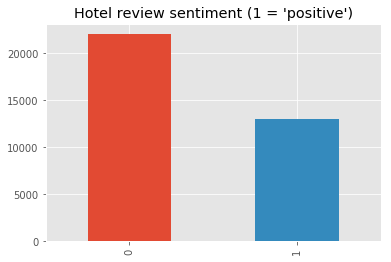

In [7]:
data.sentiment.value_counts().plot(kind='bar')
plt.title("Hotel review sentiment (1 = 'positive')")

In [8]:
# Cleaning text
def clean(review):
        review = str(review)
        review = str(review.lower())  # Lower case
        review = re.compile('[^a-z]+').sub(' ', str(review)).strip() # Remove non alphabetical numbers
        return review

# Add column review cleaned    
data['review_cleaned'] = [clean(x) for x in data['reviews.text']]

In [9]:
# Sanity check
print(data['reviews.text'][0])
print('-----------')
print(data['review_cleaned'][0])

Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!
-----------
pleasant min walk along the sea front to the water bus restaurants etc hotel was comfortable breakfast was good quite a variety room aircon didn t work very well take mosquito repelant


In [10]:
# Split dataset into train and test
data_senti = data[["sentiment" , "review_cleaned"]]
train = data_senti.sample(frac=0.8,random_state=200)
test = data_senti.drop(train.index)

print(len(train))
print(len(test))

28040
7010


In [11]:
# Call up stopwords
stopwords = STOPWORDS
stopwords.remove('not')
stopwords.remove('no')

In [12]:
# Vectorize reviews for classification: random forest, linear regression, SVM, BernouliNB, etc

# Call tfidf vectorizer, fit and transform the data 
count_vect = CountVectorizer(min_df = 2, stop_words = stopwords , ngram_range = (1,2))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train["review_cleaned"])        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test["review_cleaned"])        
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

#tfidf_vect = TfidfVectorizer(min_df = 2, stop_words = stopwords, ngram_range=(1, 2))
#X_train_tfidf = tfidf_vect.fit_transform(train['review_cleaned'])
#X_test_tfidf = tfidf_vect.fit_transform(test['review_cleaned'])

y_train = train['sentiment']
y_test = test['sentiment']

In [13]:
# Evaluate dimensionality
print('X_train:', X_train_tfidf.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test_tfidf.shape)
print('y_test:', y_test.shape)

X_train: (28040, 89627)
y_train: (28040,)
X_test: (7010, 89627)
y_test: (7010,)


In [14]:
# Instantiate different classifiers
#logreg = linear_model.LogisticRegression(solver='lbfgs' , C=10000)  # Logistic regression
#multi_NB = MultinomialNB()   # Multinomial naive bayes
#b_NB = BernoulliNB()   # Bernoulli naive bayes
#rf = RandomForestRegressor(n_estimators=20, max_depth=30, random_state=30)  # Random forest

# SVM won't be used because of its difficulty to scale


# Set up lists to store models, results and names
#models = []

#models.append(('LR', logreg))
#models.append(('Multi_NB', multi_NB))
#models.append(('Bernoulli_NB', b_NB))
#models.append(('Random_forest', rf))
    
#results = []
#names = []

## Training the model

Given that we are trying to predict whether the review was positive or negative, this involves a binary classification task. Since there is a variety of classifiers for this task with different strengths and weakneses, we attempt to try some of the compare their performace. Here we will be testing the following classifiers: Logistic Regression, Multinomial N(aive) B(ayes), Bernoulli N(aive) B(ayes), Random Fores and KNeighbors classifier. 

These classifiers will be evaluated with regard to their accuracy in both the train and test data, prediction accuracy and log loss. A dataframe is created to store this information and another dataframe to contain the review predictions for each classifier. 

After running the models, we find the the BernoulliNB classifier obtains the highest performance: 75.69%. Furthermore, it is the BernoulliNB classifier that also has the highest ROC AUC value: .77. 

In [15]:
classifiers = [linear_model.LogisticRegression(solver='lbfgs' , C=10000), 
              MultinomialNB(), 
              BernoulliNB(), 
              RandomForestClassifier(n_estimators=20, max_depth=30, random_state=30), 
              KNeighborsClassifier()]

In [16]:
# Create a dataframe with results
results_cols = ['Classifier', 'Train score', 'Test score', 'Accuracy', 'Log Loss']
results = pd.DataFrame(columns = results_cols)

predictions_cols = ['Logistic_regression', 'MultinomialNB', 'BernoulliNB', 'RandomForest', 'KNeighbors']
predictions = pd.DataFrame()

In [17]:
# Run classifiers

for clf in classifiers:
    clf.fit(X_train_tfidf, y_train)
    
    name = clf.__class__.__name__
    
    print('='*30)
    print(name)
    
    print('**** Results ****')
    train_score = clf.score(X_train_tfidf, y_train)
    test_score = clf.score(X_test_tfidf, y_test)
    print('Train score: {:.4%}'.format(train_score))
    print('Test score: {:.4%}'.format(test_score))
    
    prediction = clf.predict(X_test_tfidf)
    acc = accuracy_score(y_test, prediction)
    print("Accuracy: {:.4%}".format(acc))
    log_predictions = pd.DataFrame(prediction.tolist())
    predictions = pd.concat([predictions, log_predictions], axis = 1)
    
    
    train_predictions = clf.predict_proba(X_test_tfidf)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    #acc and ll have been removed
    log_entry = pd.DataFrame([[name, train_score, test_score, acc, ll]], columns = results_cols)
    results = results.append(log_entry)

LogisticRegression
**** Results ****
Train score: 98.0884%
Test score: 73.1954%
Accuracy: 73.1954%
Log Loss: 1.599029948996817
MultinomialNB
**** Results ****
Train score: 83.4629%
Test score: 74.2939%
Accuracy: 74.2939%
Log Loss: 0.49556609892741993
BernoulliNB
**** Results ****
Train score: 82.7960%
Test score: 75.6919%
Accuracy: 75.6919%
Log Loss: 1.461166745324262
RandomForestClassifier
**** Results ****
Train score: 72.3502%
Test score: 66.8616%
Accuracy: 66.8616%
Log Loss: 0.5856102467161411
KNeighborsClassifier
**** Results ****
Train score: 72.8174%
Test score: 57.7746%
Accuracy: 57.7746%
Log Loss: 1.7583295665041503


In [18]:
# Check out results
results.head()

,Classifier,Train score,Test score,Accuracy,Log Loss
0,LogisticRegression,0.980884,0.731954,0.731954,1.599030
0,MultinomialNB,0.834629,0.742939,0.742939,0.495566
0,BernoulliNB,0.827960,0.756919,0.756919,1.461167
0,RandomForestClassifier,0.723502,0.668616,0.668616,0.585610
0,KNeighborsClassifier,0.728174,0.577746,0.577746,1.758330


In [19]:
# Check out results: predictions
predictions.columns = predictions_cols
print(predictions.head())
print(predictions.shape)

   Logistic_regression  MultinomialNB  BernoulliNB  RandomForest  KNeighbors
0                    0              0            1             0           1
1                    0              0            1             0           1
2                    0              1            1             1           1
3                    0              1            1             1           0
4                    1              0            0             0           0
(7010, 5)


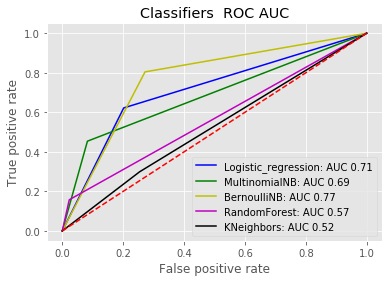

In [20]:
# Further metrics ROC

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predict in predictions.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers  ROC AUC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.show()

## Further steps

The next steps of this project involve mainly improving the model performance. For this, a number of different approaches will be tried:

    - Keep the difference in (upper) case in certain words that could help the classifier make the class distinction. 
    - Adjust the rating threshold in order to show better the contrast between positive and negative review, e.g. have a more polarized system for classifying rewies. 
    - Add additional models to evaluate their performance. 
    - Tune manually the models hyperparameters using grid serach.
    - Add additional features to be used by the classifiers: metadata, review title, etc. 
    - Try a model using neural networks. 

In [21]:
# Further analysis

    # Try neural networks
    # Try feature extraction and dimensionality reduction
    # Try adding additional features, eg. date, location, headline text, etc
    # Grid search: tune hyper parameters
    # Add other models: Maximun entropy model, SVC, GradientBoostingClasssifier

### References
https://www.brightlocal.com/2014/08/14/5-visual-stats-power-of-online-reviews/